# LANL Earthquake Prediction Kaggle Competition



Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

In this competition, we will address **when** the earthquake will take place. Specifically, we’ll predict **the time remaining** before laboratory earthquakes occur from real-time seismic data.

Together we will cover the first place solution.

Our steps will be :
*  1 - Installing dependencies
*  2 - Importing dataset
*  3 - Exploratory data analysis
*  4 - Feature engineering
*  5 - Create Test and Train Sets
*  6 - Preparing Cross Validation 
*  7 - Train The LightGBM
*  8 - Train The NN
*  9 - Combine NN and LGBM using geometric mean

## 1- Installing Dependencies

In [3]:
from tensorflow import keras
from keras.layers import (BatchNormalization,Flatten,Convolution1D,Activation,Input,Dense,LSTM)
from tsfresh.feature_extraction import feature_calculators
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import Sequence, to_categorical
from sklearn.metrics import mean_absolute_error
from keras.callbacks import ReduceLROnPlateau
from keras import losses, models, optimizers
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
import lightgbm as lgb
import seaborn as sns
import random as rn
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import warnings
import librosa
import pywt
import os
import gc

#it will help us to download the data stored in Kaggle
!pip install kaggle
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline

Using TensorFlow backend.


## 2- Importing Dataset


In [8]:
#Kaggle API to download the dataset
#it will take about 120 seconds

!kaggle competitions download --force LANL-Earthquake-Prediction

^C


In [2]:
# to find PATH
print(os.getcwd())

C:\Users\dell


In [3]:
# changing Path from C:\Users\dell to C:\Users\dell\LANL-Data
path = r"C:\Users\dell\LANL-Data"
os.chdir( path )


In [4]:
#check  
print(os.getcwd())

C:\Users\dell\LANL-Data


In [5]:
# to see what is inside of LANL-Data
print(os.listdir(os.getcwd()))

['sample_submission.csv', 'test', 'train.csv']


## 3- Exploratory Data Analysis

### Trainining Data : ###

* The training data is a single, continuous segment of experimental data.

* The data is recorded in bins of 4096 samples. Within those bins seismic data is recorded at 4MHz, but there is a 12 microseconds gap between each bin, an artifact of the recording device.

* There are 629,145,480 data points in the training set to train on--this is about 157 seconds of data. 

* The dimension of the data is quite large, in excess of 600 millions rows of data.


In [6]:
raw = pd.read_csv("train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}) 

In [7]:
raw.head(7)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691


**acoustic_data**  can be interpreted as a seismic signal 

**time_to_failure** corresponds to the time until the laboratory earthquake takes place (quaketime)

When we look at the quaketime (time_to_failure) of these first rows seems to be always the same. But it is not true.


In [8]:
for n in range(5):
    print(raw.time_to_failure.values[n])

1.4690999832
1.4690999821000001
1.4690999809999998
1.4690999799000002
1.4690999787999999


We can see that they are not the same and that pandas has rounded them off. And we can see that the time seems to decrease.

In [12]:
del raw
raw = pd.read_csv("train.csv", dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}) 

In [13]:
# functions for the  plots below
def single_timeseries(final_idx, init_idx=0, step=1, title="",
                      color1='pink', color2='purple'):
    idx = [i for i in range(init_idx, final_idx, step)]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    fig.suptitle(title, fontsize=14)
    
    ax2 = ax1.twinx()
    ax1.set_xlabel('index')
    ax1.set_ylabel('Acoustic data')
    ax2.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=raw.iloc[idx].acoustic_data.values, ax=ax1, color=color1)
    p2 = sns.lineplot(data=raw.iloc[idx].time_to_failure.values, ax=ax2, color=color2)
    
def double_timeseries(final_idx1, final_idx2, init_idx1=0, init_idx2=0, step=1, title=""):
    idx1 = [i for i in range(init_idx1, final_idx1, step)]
    idx2 = [i for i in range(init_idx2, final_idx2, step)]
    
    fig, (ax1a, ax2a) = plt.subplots(1,2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.4)
    ax1b = ax1a.twinx()
    ax2b = ax2a.twinx()
    
    ax1a.set_xlabel('index')
    ax1a.set_ylabel('Acoustic data')
    ax2a.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=raw.iloc[idx1].acoustic_data.values, ax=ax1a, color='pink')
    p2 = sns.lineplot(data=raw.iloc[idx1].time_to_failure.values, ax=ax1b, color='purple')
    
    p3 = sns.lineplot(data=raw.iloc[idx2].acoustic_data.values, ax=ax2a, color='pink')
    p4 = sns.lineplot(data=raw.iloc[idx2].time_to_failure.values, ax=ax2b, color='purple')


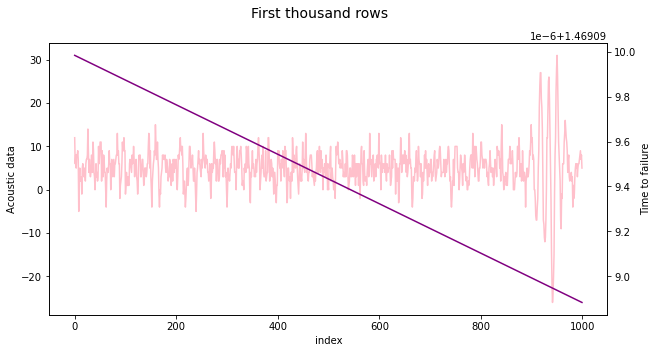

In [15]:
single_timeseries(1000, title="First thousand rows")

The time to failure (TTF) is linearly decreasing at a very slow rate. However, when looking at ten thousand rows it's possible to see some "jumps":

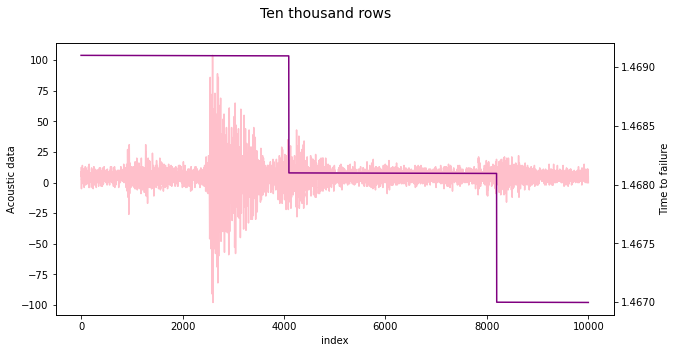

In [16]:
single_timeseries(10000, title="Ten thousand rows")

According to this discussion:

The data is recorded in bins of 4096 samples. Within those bins, there is a 12 microseconds (1e-6) gap between each bin, as an artifact of the recording device.

Therefore, the "jumps" have 12 microseconds and occur every 4096 measurements.

The next plot has ten million rows, but we are plotting only every 10 data points:

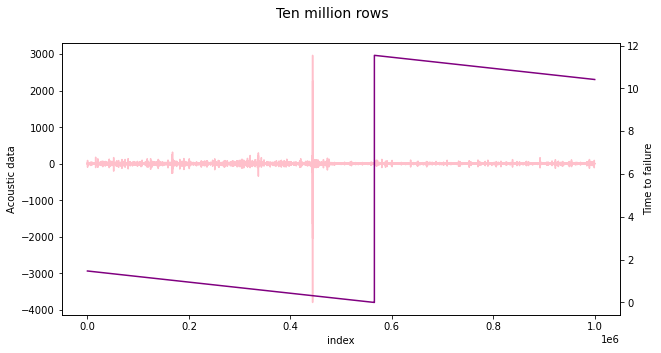

In [17]:
single_timeseries(10000000, step=10, title="Ten million rows")

We can't see the jumps anymore; it's as if we have stretched the line and the steps disappeared. There is only one huge change in TTF, which is exactly when an earthquake occured and the time goes from almost zero to eleven seconds.

Finally, let's plot all the data (629.145 million rows):

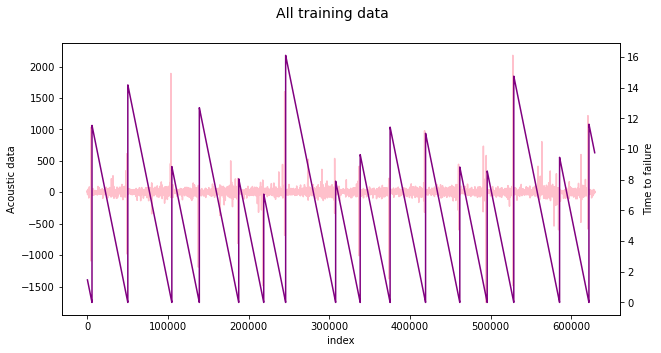

In [14]:
single_timeseries(629145000, step=1000, title="All training data")

There are 16 earthquakes in the train set and that they occur when time_to_failure (quaketime) goes to 0. 

The shortest time to failure is 1.5 seconds for the first earthquake, while the longest is around 16 seconds.

In [2]:
# to plot the plots of median and mean 

low = np.mean(raw.acoustic_data) - 3 * np.std(raw.acoustic_data)
high = np.mean(raw.acoustic_data) + 3 * np.std(raw.acoustic_data) 
sns.distplot(raw.loc[(raw.acoustic_data >= low) & (raw.acoustic_data <= high), "acoustic_data"].values,
             ax=ax[1],
             color="Orchid",
             bins=150, kde=False)
ax[1].set_xlabel("acoustic_data")
ax[1].set_ylabel("Density")
ax[1].set_title("acoustic_data distribution without peaks");

NameError: name 'np' is not defined

This  plot shows the signal at the median and mean around 4. We can see that it looks very gaussian and balanced. It seems that the signal is somehow discrete.

### Test Data : ###

* The test data consists of a folder containing many small segments that may (or may not) correspond to different experiments. The regular pattern we might find in the train set does not match those of the test segments.

* Each segment only has 150,000 data points of seismic data, which corresponds to 0.0375 seconds of seismic data.

* The data *within* each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

* For each test data segment with its corresponding seg_id we are asked to predict **it's single time until the lab earthquake takes place**.

*  There is no overlap between the training and testing sets, that are contiguous in time.

How does the signal of the test data look like?

In [42]:
#changing path from C:\Users\dell\LANL-Data to C:\Users\dell\LANL-Data\test

test_path = r"C:\Users\dell\LANL-Data\test"
os.chdir( test_path )

#check
print(os.getcwd())


C:\Users\dell\LANL-Data\test


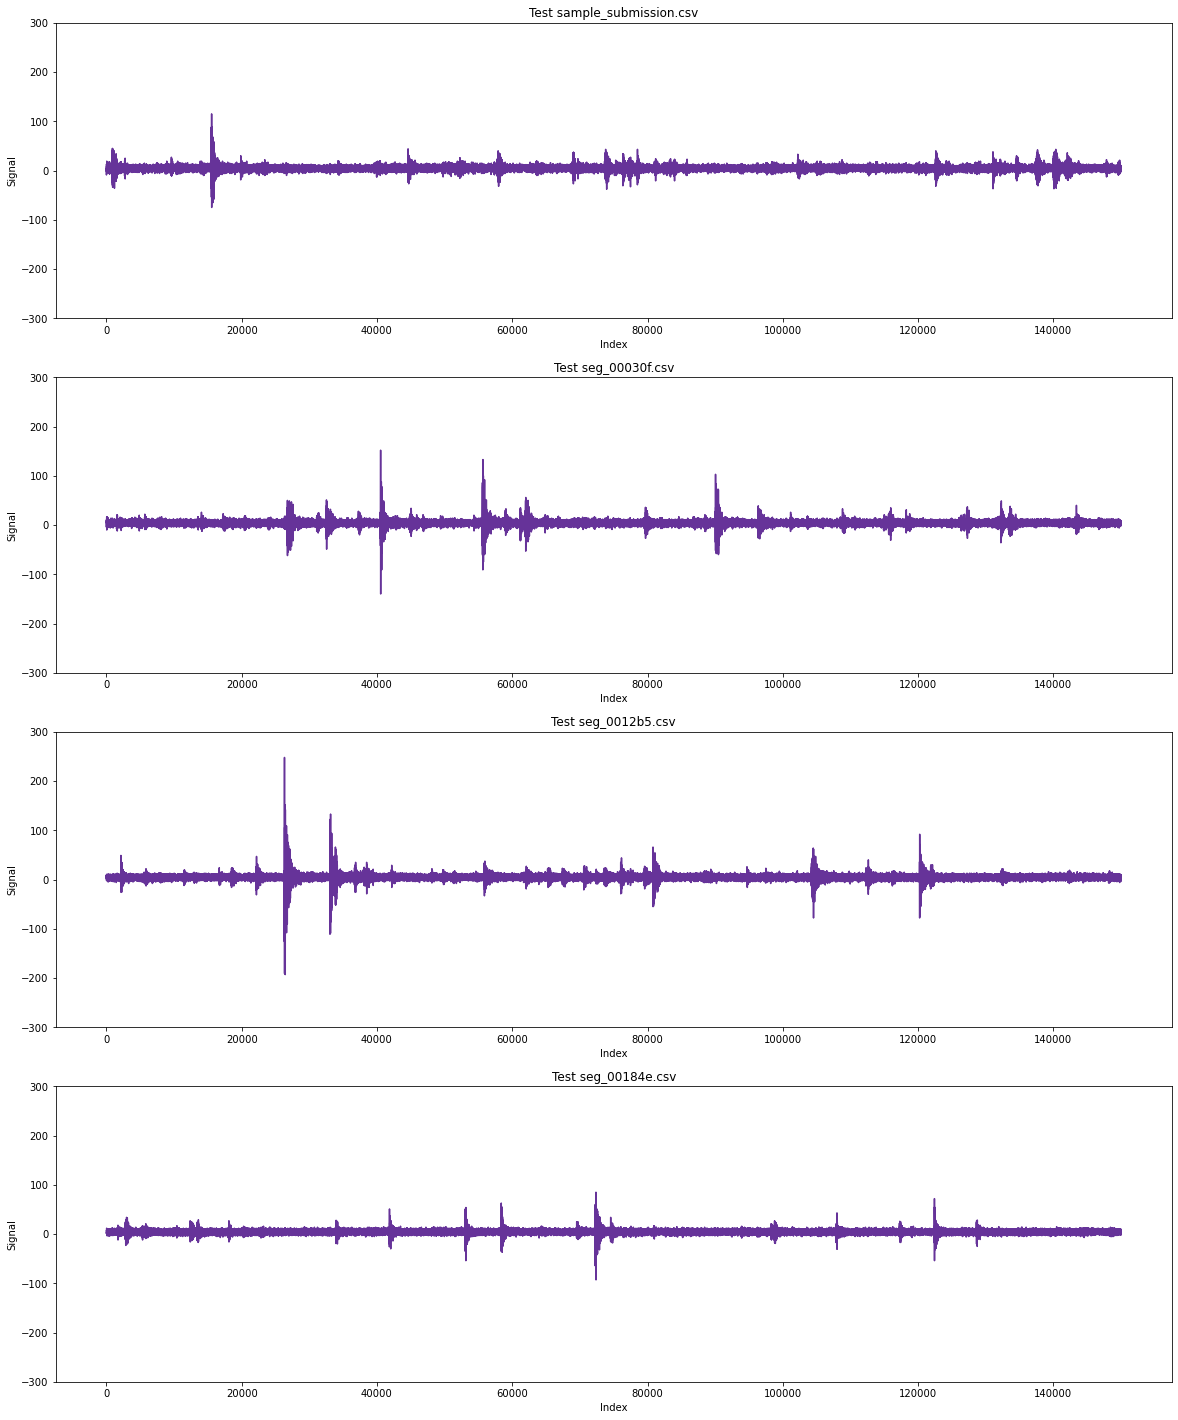

In [58]:
test_files = os.listdir(os.getcwd())  #attaching list of files inside test file to test_file
fig, ax = plt.subplots(4,1, figsize=(20,25))

for n in range(4):
    seg = pd.read_csv(test_path +str( "\\" ) + str(test_files[n+1]))
    ax[n].plot(seg.acoustic_data.values, c="rebeccapurple")
    ax[n].set_xlabel("Index")
    ax[n].set_ylabel("Signal")
    ax[n].set_ylim([-300, 300])
    ax[n].set_title("Test {}".format(test_files[n]));

These test segment examples differ a lot in the occurences of small peaks that seem to be similar to those in the train data before and after the heavy signal peak that occured some time before the lab earthquake took place.
They probably came from the same experiment but do neither form a continuous signal nor directly follow after the train data.

## 4- Feature Engineering ##

### Functions for parsing and feature generation: ###

##### Normalization function #####

In [61]:
# The normalize function is required to normalize the data for the neural network.

def normalize(X_train, X_valid, X_test, normalize_opt, excluded_feat):
    feats = [f for f in X_train.columns if f not in excluded_feat]
    if normalize_opt != None:
        if normalize_opt == 'min_max':
            scaler = preprocessing.MinMaxScaler()
        elif normalize_opt == 'robust':
            scaler = preprocessing.RobustScaler()
        elif normalize_opt == 'standard':
            scaler = preprocessing.StandardScaler()
        elif normalize_opt == 'max_abs':
            scaler = preprocessing.MaxAbsScaler()
        scaler = scaler.fit(X_train[feats])
        X_train[feats] = scaler.transform(X_train[feats])
        X_valid[feats] = scaler.transform(X_valid[feats])
        X_test[feats] = scaler.transform(X_test[feats])
    return X_train, X_valid, X_test

[?] The python-fit module is designed for fitting data simple and painless

##### Create random noise for robustness #####

**Robustness**  is the ability of a computer system to cope with errors during execution and cope with erroneous input. For a machine learning algorithm to be considered robust, either the testing error has to be consistent with the training error, or the performance is stable after adding some noise to the dataset.

*WHY DO WE ADD RANDOM NOISE?* 


Because the signal had a certain time-trend that caused some issues specifically on mean and quantile based features. To partly overcome this, we will add a constant noise to each 150k segment (both in train and test) by calculating np.random.normal(0, 0.5, 150_000). Additionally, after noise addition, we will subtract the median of the each segment.

In [62]:
np.random.seed(1337)
noise = np.random.normal(0, 0.5, 150_000)

#####  Mean Absolute Deviation #####

The absolute mean deviation measures the spread and scatteredness of data around, preferably the median value, in terms of absolute deviation. 

In [63]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

With **d - np.mean(d,axis)**, we extract mean from every element of array d


##### Denoise the raw signal given a segment x #####

In [64]:
def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")  
    sigma = (1/0.6745) * maddest(coeff[-level])
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per') 

**pywt.wavedec** = Multilevel 1D Discrete Wavelet Transform of data.

**pywt.threshold** = Thresholds the input data depending on the mode argument.In hard thresholding, the data values where their absolute value is less than the value param are replaced with substitute. Data values with absolute value greater or equal to the thresholding value stay untouched.

**pywt.waverec** = Multilevel 1D Inverse Discrete Wavelet Transform of data.

##### Denoise the raw signal (simplified) given a segment x #####

In [65]:
def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    #univeral threshold
    uthresh = 10
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

The only difference between **denoise_signal** and **denoise_signal_simple** is the threshold values. For the first one we calculate threshold value,however, for the second we specify a constant threshold value.


#####  Generate the features given a segment z #####

In [66]:
def feature_gen(z):
    X = pd.DataFrame(index=[0], dtype=np.float64) #create an empty Dataframe named X 
    
    # Add noise, subtract median to remove bias from mean/median as time passes in the experiment
    # Save the result as a new segment, z
    
    z = z + noise
    z = z - np.median(z)

    # Save denoised versions of z
    den_sample = denoise_signal(z)
    den_sample_simple = denoise_signal_simple(z)
    
    # Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(z)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_denoise_simple = librosa.feature.mfcc(den_sample_simple)
    mfcc_mean_denoise_simple = mfcc_denoise_simple.mean(axis=1) #0-19
    
    # Spectral contrast
    lib_spectral_contrast_denoise_simple = librosa.feature.spectral_contrast(den_sample_simple).mean(axis=1) #0-6
    lib_spectral_contrast = librosa.feature.spectral_contrast(z).mean(axis=1) #0-6
    
    # Neural network features
    X['NN_zero_crossings_denoise'] = len(np.where(np.diff(np.sign(den_sample)))[0])
    X['NN_LGBM_percentile_roll20_std_50'] = np.percentile(pd.Series(z).rolling(20).std().dropna().values, 50)
    X['NN_q95_roll20_std'] = np.quantile(pd.Series(z).rolling(20).std().dropna().values, 0.95)
    X['NN_LGBM_mfcc_mean4'] = mfcc_mean[4]
    X['NN_lib_spectral_contrast0'] = lib_spectral_contrast[0]
    X['NN_num_peaks_3_denoise'] = feature_calculators.number_peaks(den_sample, 3)
    X['NN_mfcc_mean_denoise_simple2'] = mfcc_mean_denoise_simple[2]
    X['NN_mfcc_mean5'] = mfcc_mean[5]
    X['NN_mfcc_mean2'] = mfcc_mean[2]
    X['NN_mfcc_mean_denoise_simple5'] = mfcc_mean_denoise_simple[5]
    X['NN_absquant95'] = np.quantile(np.abs(z), 0.95)
    X['NN_median_roll50_std_denoise_simple'] = np.median(pd.Series(den_sample_simple).rolling(50).std().dropna().values)
    X['NN_mfcc_mean_denoise_simple1'] = mfcc_mean_denoise_simple[1]
    X['NN_quant99'] = np.quantile(z, 0.99)
    X['NN_lib_zero_cross_rate_denoise_simple'] = librosa.feature.zero_crossing_rate(den_sample_simple)[0].mean()
    X['NN_fftr_max_denoise'] = np.max(pd.Series(np.abs(np.fft.fft(den_sample)))[0:75000])
    X['NN_abssumgreater15'] = np.sum(abs(z[np.where(abs(z)>15)]))
    X['NN_LGBM_mfcc_mean18'] = mfcc_mean[18]
    X['NN_lib_spectral_contrast_denoise_simple2'] = lib_spectral_contrast_denoise_simple[2]
    X['NN_fftr_sum'] = np.sum(pd.Series(np.abs(np.fft.fft(z)))[0:75000])
    X['NN_mfcc_mean_denoise_simple10'] = mfcc_mean_denoise_simple[10]
    
    # Extra features only LGBM used.
    X['LGBM_num_peaks_2_denoise_simple'] = feature_calculators.number_peaks(den_sample_simple, 2)
    X['LGBM_autocorr5'] = feature_calculators.autocorrelation(pd.Series(z), 5)
    
    # Windowed fast fourier transformations
    fftrhann20000 = np.sum(np.abs(np.fft.fft(np.hanning(len(z))*z)[:20000]))
    fftrhann20000_denoise = np.sum(np.abs(np.fft.fft(np.hanning(len(z))*den_sample)[:20000]))
    fftrhann20000_diff_rate = (fftrhann20000 - fftrhann20000_denoise)/fftrhann20000
    
    X['LGBM_fftrhann20000_diff_rate'] = fftrhann20000_diff_rate
    
    return X

We create a dataframe named x to store our features. ???? **DAHA ÇOK BAK ANLAMAYA ÇALIŞŞ**

## 5-Create Test and Train Sets ##

They found that the test data looks different to training data in a few ways when comparing features by applying KS statistics between train and test.

That’s when they decided to sample the train data to make it look more like they expect test data to look like (only from looking at feature distributions). They started by **manually upsampling** certain areas of train data, but gave up on that after a few tries and then they found a very nice way of aligning train and test data.

So what they did is that they calculated a handful of features for train and test and **tried to find a good subset of full earth-quakes in train, so that the overall feature distributions are similar to those of the full test data**.

They did this by sampling 10 full earthquakes multiple times (up to 10k times) on train, and comparing the average KS statistic of all selected features on the sampled earthquakes to the feature dists in full test.

The best average KS-statistic is somewhere in the range of 6.2-6.5.

After careful examination of these results, they decided in the end to subsample the train data to only consider earthquakes [2, 7, 0, 4, 11, 13, 9, 1, 14, 10] numerating all 17 earthquake cycles they have in train. 

In [88]:
def parse_sample(sample, start):
    delta = feature_gen(sample['acoustic_data'].values)
    delta['start'] = start
    delta['target'] = sample['time_to_failure'].values[-1]
    return delta
    
def sample_train_gen(df, segment_size=150_000, indices_to_calculate=[0]):
    result = Parallel(n_jobs=1, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")
(delayed(parse_sample)(df[int(i) : int(i) + segment_size], int(i)) 
 
 
for i in tqdm(indices_to_calculate))
    data = [r.values for r in result]
    data = np.vstack(data)
    X = pd.DataFrame(data, columns=result[0].columns)
    X = X.sort_values("start")
    return X


def parse_sample_test(seg_id):
    sample = pd.read_csv('test_path ' + seg_id + '.csv', dtype={'acoustic_data': np.int32})
    delta = feature_gen(sample['acoustic_data'].values)
    delta['seg_id'] = seg_id
    return delta

def sample_test_gen():
    X = pd.DataFrame()
    submission = pd.read_csv('path' + 'sample_submission.csv', index_col='seg_id')
    result = Parallel(n_jobs=1, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")
(delayed(parse_sample_test)(seg_id) for seg_id in tqdm(submission.index))
    data = [r.values for r in result]
    data = np.vstack(data)
    X = pd.DataFrame(data, columns=result[0].columns)
    return X

indices_to_calculate = raw.index.values[::150_000][:-1]

train = sample_train_gen(raw, indices_to_calculate=indices_to_calculate)
del raw
gc.collect()
test = sample_test_gen()

IndentationError: unexpected indent (<ipython-input-88-4751b9394975>, line 13)

## 6- Preparing Cross Validation ##

Now that we had sampled train data that we though to be similar to test just purely based on statistical analysis, and now that we had features that should not have any time leaks, we decided on doing a simple shuffled 3-fold on that data.

In [ ]:
# keep CV observations from train set

etq_meta = [
{"start":0,         "end":5656574},
{"start":5656574,   "end":50085878},
{"start":50085878,  "end":104677356},
{"start":104677356, "end":138772453},
{"start":138772453, "end":187641820},
{"start":187641820, "end":218652630},
{"start":218652630, "end":245829585},
{"start":245829585, "end":307838917},
{"start":307838917, "end":338276287},
{"start":338276287, "end":375377848},
{"start":375377848, "end":419368880},
{"start":419368880, "end":461811623},
{"start":461811623, "end":495800225},
{"start":495800225, "end":528777115},
{"start":528777115, "end":585568144},
{"start":585568144, "end":621985673},
{"start":621985673, "end":629145480},
]

for i, etq in enumerate(etq_meta):
    train.loc[(train['start'] + 150_000 >= etq["start"]) & (train['start'] <= etq["end"] - 150_000), "eq"] = i

# We are only keeping segments that belong in these earthquakes
# This is to make the training distribution more like the testing distribution
train_sample = train[train["eq"].isin([2, 7, 0, 4, 11, 13, 9, 1, 14, 10])]

In [ ]:
# delete unnecessary files
del train
gc.collect()

In [ ]:
# reset the index of the final train set
train_sample=train_sample.reset_index(drop=True)

In [ ]:
# create time since failure target variable
# This will be used in the NN as an additional objective
targets=train_sample[['target','start']]
targets['tsf']=targets['target']-targets['target'].shift(1).fillna(0)
targets['tsf']=np.where(targets['tsf']>1.5, targets['tsf'], 0)
targets['tsf'].iloc[0]=targets['target'].iloc[0]

temp_max=0
for i in tqdm(range(targets.shape[0])):
    if targets['tsf'].iloc[i]>0:
        temp_max=targets['tsf'].iloc[i]
    else:
        targets['tsf'].iloc[i]=temp_max
        
targets['tsf']=targets['tsf']-targets['target']

# create a flag target variable for TTF<0.5 secs
# This will be used in the NN as an additional objective
target=targets['target'].copy().values
target[target>=0.5]=1
target[target<0.5]=0
target=1-target

targets['binary']=target
del target
gc.collect()

In [ ]:
# import submission file
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [ ]:
# delete unnecessary columns
train_sample.drop(['start', 'target', 'eq'],axis=1,inplace=True)
test.drop(['seg_id'],axis=1,inplace=True)

In [ ]:
# We also need to convert test columns from objects to float64
test = test.astype('float64')

In [ ]:
# Define your kfold cross validation
# We used 3 folds, because we did not see improvements with higher folds
# We are not scared of shuffling because The whole point of this comp is to be independent of time. Test is shuffled
n_fold = 3

kf = KFold(n_splits=n_fold, shuffle=True, random_state=1337)
kf = list(kf.split(np.arange(len(train_sample))))

## 7- Train LGBM ##

In [ ]:
LGBM_feats = [feat for feat in train_sample.columns if 'LGBM' in feat]
print('The features LGBM is using are:', LGBM_feats)

In [ ]:
oof_LGBM = np.zeros(len(train_sample))
sub_LGBM = np.zeros(len(submission))
seeds = [0,1,2,3,4,5,6,7,8,9]

for seed in seeds:
    print('Seed',seed)
    for fold_n, (train_index, valid_index) in enumerate(kf):
        print('Fold', fold_n)

        # Create train and validation data using only LGBM_feats.
        trn_data = lgb.Dataset(train_sample[LGBM_feats].iloc[train_index], label=targets['target'].iloc[train_index])
        val_data = lgb.Dataset(train_sample[LGBM_feats].iloc[valid_index], label=targets['target'].iloc[valid_index])

        params = {'num_leaves': 4, # Low number of leaves reduces LGBM complexity
          'min_data_in_leaf': 5,
          'objective':'fair', # Fitting to fair objective performed better than fitting to MAE objective
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt", 
          'boost_from_average': True,
          "feature_fraction": 0.9,
          "bagging_freq": 1,
          "bagging_fraction": 0.5,
          "bagging_seed": 0,
          "metric": 'mae',
          "verbosity": -1,
          'max_bin': 500,
          'reg_alpha': 0, 
          'reg_lambda': 0,
          'seed': seed,
          'n_jobs': 1
          }

        clf = lgb.train(params, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)

        oof_LGBM[valid_index] += clf.predict(train_sample[LGBM_feats].iloc[valid_index], num_iteration=clf.best_iteration)
        sub_LGBM += clf.predict(test[LGBM_feats], num_iteration=clf.best_iteration) / n_fold
        
oof_LGBM = oof_LGBM / len(seeds)
sub_LGBM = sub_LGBM / len(seeds)
    
print('\nMAE for LGBM: ', mean_absolute_error(targets['target'], oof_LGBM))

## 8- Train the NN ##

In [ ]:
NN_feats = [feat for feat in train_sample.columns if 'NN' in feat]
print('The features NN is using are:', NN_feats)

In [ ]:
# Subset columns to only use the neural network features
train_sample = train_sample[NN_feats]
test = test[NN_feats]

In [ ]:
#Define Neural Network architecture
def get_model():

    inp = Input(shape=(1,train_sample.shape[1]))
    x = BatchNormalization()(inp)
    x = LSTM(128,return_sequences=True)(x) # LSTM as first layer performed better than Dense.
    x = Convolution1D(128, (2),activation='relu', padding="same")(x)
    x = Convolution1D(84, (2),activation='relu', padding="same")(x)
    x = Convolution1D(64, (2),activation='relu', padding="same")(x)

    x = Flatten()(x)

    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    
    #outputs
    ttf = Dense(1, activation='relu',name='regressor')(x) # Time to Failure
    tsf = Dense(1)(x) # Time Since Failure
    classifier = Dense(1, activation='sigmoid')(x) # Binary for TTF<0.5 seconds
    
    model = models.Model(inputs=inp, outputs=[ttf,tsf,classifier])    
    opt = optimizers.Nadam(lr=0.008)

    # We are fitting to 3 targets simultaneously: Time to Failure (TTF), Time Since Failure (TSF), and Binary for TTF<0.5 seconds
    # We weight the model to optimize heavily for TTF
    # Optimizing for TSF and Binary TTF<0.5 helps to reduce overfitting, and helps for generalization.
    model.compile(optimizer=opt, loss=['mae','mae','binary_crossentropy'],loss_weights=[8,1,1],metrics=['mae'])
    return model

The real interesting thing here is that **they do multi-task learning by specifying additional losses next to the ttf loss that they weight higher than the others**.

They have one additional binary logloss with the target specifying if the ttf is <0.5 and one further MAE loss on the target of time-since-failure. This helped to balance some of the predictions out a bit and specifically helped to better predict some of the areas at the end of earthquakes that make some weird spikes. 

In [ ]:
n=8 # number of NN runs

oof_final = np.zeros(len(train_sample))
sub_final = np.zeros(len(submission))
i=0


while i<8:
    print('Running Model ', i+1)
    
    oof = np.zeros(len(train_sample))
    prediction = np.zeros(len(submission))

    for fold_n, (train_index, valid_index) in enumerate(kf):
        #define training and validation sets

        train_x=train_sample.iloc[train_index] #training set
        train_y_ttf=targets['target'].iloc[train_index] #training target(Time to Failure)

        valid_x=train_sample.iloc[valid_index] #validation set
        valid_y_ttf=targets['target'].iloc[valid_index] #validation target(Time to Failure)

        train_y_tsf=targets['tsf'].iloc[train_index] #training target(Time Since Failure)
        train_y_clf=targets['binary'].iloc[train_index] #training target(Binary for TTF<0.5 Secs)

        valid_y_tsf=targets['tsf'].iloc[valid_index] #validation target(Time Since Failure)
        valid_y_clf=targets['binary'].iloc[valid_index] #validation target(Binary for TTF<0.5 Secs)

        #apply min max scaler on training, validation data
        train_x,valid_x,test_scaled=normalize(train_x.copy(), valid_x.copy(), test.copy(), 'min_max', [])

        #Reshape training,validation,test data for fitting
        train_x=train_x.values.reshape(train_x.shape[0],1,train_x.shape[1])
        valid_x=valid_x.values.reshape(valid_x.shape[0],1,valid_x.shape[1])
        test_scaled=test_scaled.values.reshape(test_scaled.shape[0],1,test_scaled.shape[1])

        #obtain Neural Network Instance
        model=get_model()

        #setup Neural Network callbacks
        cb_checkpoint = ModelCheckpoint("model.hdf5", monitor='val_regressor_mean_absolute_error', save_weights_only=True,save_best_only=True, period=1)
        cb_Early_Stop=EarlyStopping( monitor='val_regressor_mean_absolute_error',patience=20)
        cb_Reduce_LR = ReduceLROnPlateau(monitor='val_regressor_mean_absolute_error', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

        callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR] #define callbacks set
        
        ### NN seeds setup- Start
        os.environ['PYTHONHASHSEED'] = '0'
        np.random.seed(1234)
        rn.seed(1234)
        tf.set_random_seed(1234)
        session_conf = tf.ConfigProto( allow_soft_placement=True)
        sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
        K.set_session(sess)
        ### NN seeds setup- End
        
        
        model.fit(train_x,[train_y_ttf,train_y_tsf,train_y_clf],
                  epochs=1000,callbacks=callbacks
                  ,batch_size=256,verbose=0,
                  validation_data=(valid_x,[valid_y_ttf,valid_y_tsf,valid_y_clf]))

        model.load_weights("model.hdf5")
        
        oof[valid_index] += model.predict(valid_x)[0].ravel()
        prediction += model.predict(test_scaled)[0].ravel()/n_fold
        
        K.clear_session()
        
    # Obtain the MAE for this run.
    model_score=mean_absolute_error(targets['target'], oof)
    
    # Sometimes, the NN performs very badly. This happens if the weights are initialized poorly.
    # If the MAE is < 2, then the model has performed correctly, and we will use it in the average.
    if model_score < 2:
        print('MAE: ', model_score,' Averaged')
        oof_final += oof/n
        sub_final += prediction/n
        i+=1 # Increase i, so we know that we completed a successful run.
        
    # If the MAE is >= 2, then the NN has performed badly.
    # We will reject this run in the average.
    else:
        print('MAE: ', model_score,' Not Averaged')

print('\nMAE for NN: ', mean_absolute_error(targets['target'], oof_final))

## 9- Combine NN and LGBM using geometric mean ##

Our final submit is a hillclimber blend of three types of models:

(i) LGB,

(ii) SVR, 

(iii) NN. 

The overall CV score on this was ~1.83. The LGB is using a fair loss with relatively moderate other hyperparameters. The SVR is also quite simply set-up. The NN is a bit more complicated with a few layers on top of a bunch of features.

The NN had the best single MAE, but blending improved. Actually, **just blending LGB and NN would have produced the best private LB score (2.25909). Adding SVR did improve CV though**. Methods specified in bold written sentences done in order to improve LB score in Kaggle.

In [ ]:
# Square root requires non-negative values, so let us force minima to something small.
MIN_VALUE = 0.1

# Correct LGBM predictions
oof_LGBM[oof_LGBM < MIN_VALUE] = MIN_VALUE
sub_LGBM[sub_LGBM < MIN_VALUE] = MIN_VALUE

# Correct NN predictions
oof_final[oof_final < MIN_VALUE] = MIN_VALUE
sub_final[sub_final < MIN_VALUE] = MIN_VALUE

*  The metric we were graded on was Mean Absolute Error (MAE).


In [ ]:
print('MAE for LGBM was: ', mean_absolute_error(targets['target'], oof_LGBM))
print('MAE for NN was  : ', mean_absolute_error(targets['target'], oof_final))

oof_geomean = (oof_LGBM * oof_final) ** (1/2)
sub_geomean = (sub_LGBM * sub_final) ** (1/2)

print('\nMAE for geometric mean of LGBM and NN was : ', mean_absolute_error(targets['target'], oof_geomean))

In [ ]:
# Save oof and sub as numpy arrays
np.save('oof_LGBM.npy', oof_LGBM)
np.save('sub_LGBM.npy', sub_LGBM)
np.save('oof_NN.npy', oof_final)
np.save('sub_NN.npy', sub_final)
np.save('oof_geomean.npy', oof_geomean)
np.save('sub_geomean.npy', sub_geomean)

In [ ]:
# Save out the geometric mean submission
submission['time_to_failure'] = sub_geomean
print(submission.head())
submission.to_csv('submission_geomean.csv')

In [ ]:
# Save solution using just LGBM
submission['time_to_failure'] = sub_LGBM
print(submission.head())
submission.to_csv('submission_LGBM.csv')

In [ ]:
# Save solution using just NN
submission['time_to_failure'] = sub_final
print(submission.head())
submission.to_csv('submission_NN.csv')